In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append("../src/")
from tp_review import *

In [2]:
dataset = pd.read_csv('../data/train.csv',sep=';')

### Exploration des données

In [3]:
dataset.head()

,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,77d2dbd504b933ab3aaf7cb0cd81c22f7c3549012f4f88...,1
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              60000 non-null  int64 
 1   review_content  60000 non-null  object
 2   review_title    59997 non-null  object
 3   review_stars    60000 non-null  int64 
 4   product         60000 non-null  object
 5   Target          60000 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 2.7+ MB


**Two equal reviews
generally have the same label ?**

In [5]:
duplicates = dataset[dataset.duplicated(subset='review_content', keep=False)]
label_check = duplicates.groupby('review_content')['Target'].nunique()
label_check.value_counts()

Target
1    1022
2     143
Name: count, dtype: int64

Text(0, 0.5, 'Nombre de critiques')

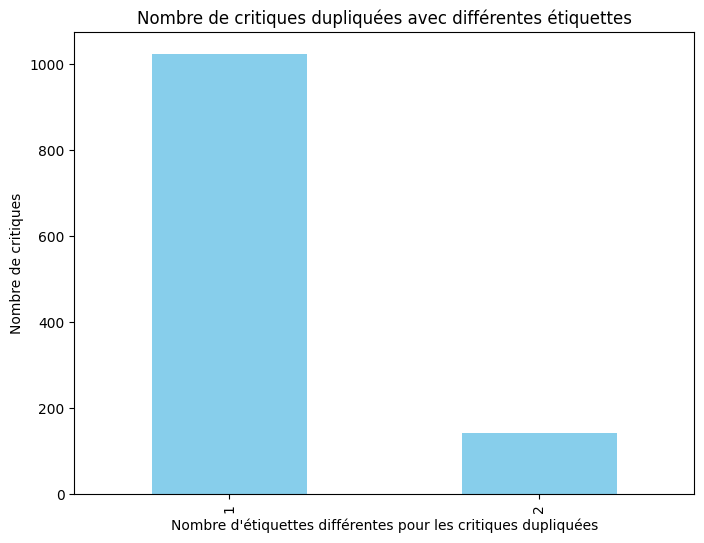

In [6]:
# Visualisation des critiques dupliquées avec plusieurs étiquettes différentes
# Compte combien de critiques dupliquées ont des étiquettes conflictuelles
conflicting_counts = label_check.value_counts()

plt.figure(figsize=(8, 6))
conflicting_counts.plot(kind='bar', color='skyblue')
plt.title("Nombre de critiques dupliquées avec différentes étiquettes")
plt.xlabel("Nombre d'étiquettes différentes pour les critiques dupliquées")
plt.ylabel("Nombre de critiques")

**Commentaires :**

Comme suggéré dans le poly du cours, on peut effectivement supprimé les *review* dupliquées car genéralement,
deux review ont le même label.

- je vais aussi supprimer la colonne *product* en même temps

In [7]:
dataset_cleaned = pre_process_data(dataset)

In [8]:
dataset_cleaned.shape

(53636, 5)

#### Extraction des features syntaxiques

**Longueur du texte (nombre de caractères/mots) :**

In [9]:
dataset_cleaned = extract_words_char_in_review(dataset_cleaned)

In [10]:
dataset_cleaned.head()

,ID,review_content,review_title,review_stars,Target,content_nb_char,content_nb_words
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,0,382,62
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,1,1000,179
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,0,192,32
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,1,106,18
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,1,124,21


**Présence de mots-clés :** 

But ? détecter les mots-clés dans le contenu et les retourner


In [11]:
dataset_cleaned['keyword_count'] = dataset['review_content'].apply(count_keywords)

In [12]:
dataset_cleaned.head()

,ID,review_content,review_title,review_stars,Target,content_nb_char,content_nb_words,keyword_count
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,0,382,62,[]
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,1,1000,179,"[bon, excellent]"
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,0,192,32,[bien]
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,1,106,18,[bon]
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,1,124,21,[bien]


**Analyse des sentiments par étoiles :**

On va créer une colonne binaire pour les avis positifs (3-5 étoiles) et négatifs (1-2 étoiles) 

In [13]:
dataset_cleaned = add_sentiment(dataset_cleaned)

Text(0, 0.5, "Nombre d'avis")

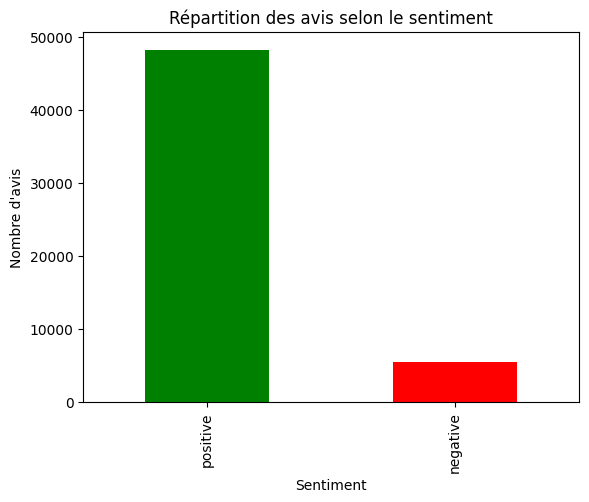

In [14]:
# Visualiser la répartition
dataset_cleaned['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title("Répartition des avis selon le sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Nombre d'avis")

In [15]:
dataset_cleaned['sentiment'].value_counts()

sentiment
positive    48234
negative     5402
Name: count, dtype: int64

**Commentaires :**

la distribution des classes n'est pas uniforme, on a plus d'avis positives que d'avis négatives

In [16]:
dataset_cleaned[dataset_cleaned.sentiment == 'positive'].head()

,ID,review_content,review_title,review_stars,Target,content_nb_char,content_nb_words,keyword_count,sentiment
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,0,382,62,[],positive
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,1,1000,179,"[bon, excellent]",positive
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,0,192,32,[bien],positive
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,1,106,18,[bon],positive
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,1,124,21,[bien],positive


In [17]:
dataset_cleaned[dataset_cleaned.sentiment == 'negative'].head()

,ID,review_content,review_title,review_stars,Target,content_nb_char,content_nb_words,keyword_count,sentiment
31,31,Boitier dus que dur externe ADDITEX Alu.\nLe b...,Des problemes à gogo,1,1,417,71,[],negative
40,40,il a marché 2 jours et depuis il ne marche plu...,forest gun,2,1,105,22,[bien],negative
63,63,puce graphique nvidia deffectueuse reconnue pa...,appareil deffectueux a long terme,1,0,77,11,[],negative
76,76,Attention cette st vous font payer des frais d...,ATTENTION AU S.A.V.,1,1,296,49,[],negative
94,94,Ca ne marche pas...\naucune possibilité de lir...,lecteur MP3 VD-tech,1,1,62,11,[],negative


**Remarques :**

En ajoutant la colonne *sentiment*, j'ai constaté une incohérence entre la colonne Target et le sentiment réel des avis.
En effet, je pensais que la colonne Target, permettait de savoir si une review est positive (1) ou negative (0). Mais là,
en filtrant sur [sentiment == négative], j'observe des 0 et 1 dans la colonne Target. 
Exemple :
- ligne 40 => target = 1
- ligne 63 => target = 0

On ne peut pas se baser donc sur la colonne Target, pour dire qu'une review est positive ou pas.

UPDATE : La colonne Target désigne si l'avis est pertinent ou non, ou un autre critère spécifique).

####  Notre premier modéle :

In [18]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

**Premier model :**

In [22]:
dataset_cleaned_copy = dataset_cleaned.copy()

X = dataset_cleaned_copy[['content_nb_char', 'content_nb_words','review_stars']]
y = dataset_cleaned_copy['Target']

model = LogisticRegression(max_iter=500,random_state=42)
train_model(model,X,y)

              precision    recall  f1-score   support

           0       0.49      0.06      0.10      4611
           1       0.57      0.95      0.72      6117

    accuracy                           0.57     10728
   macro avg       0.53      0.51      0.41     10728
weighted avg       0.54      0.57      0.45     10728



Nos scores ne sont pas fameux...

In [23]:
pickle.dump(model,open('../src/logistic_reg_review','wb'))